# 微分可能LUTモデルによるMNISTでの Auto Encoder 学習

Differentiable LUTモデルを用いて MNIST 画像の Auto Encoder を作成してみます。<br>
ネットワークモデルにはCNNを用いています。
バイナリであっても今のところある程度機能しており、一度 32ch まで圧縮した後に復元させています。

## 事前準備

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

import torch
import torchvision
import torchvision.transforms as transforms

import binarybrain as bb

異なる閾値で2値化した画像でフレーム数を水増ししながら学習させます。この水増しをバイナリ変調と呼んでいます。<br>
ここではフレーム方向の水増し量を frame_modulation_size で指定しています。<br>
別途 CIFAR-10などでも実験していますが、変調によりバイナリであってもある程度の階調表現の復元が行えるようです。

In [2]:
# configuration
bin_mode              = True
epochs                = 4
net_name              = 'MnistAeDifferentiableLutCnn'
data_path             = './data/' + net_name
frame_modulation_size = 7

データセットは PyTorch の torchvision を使います。<br>
BinaryBrainではミニバッチをフレーム数として FrameBufferオブジェクトで扱います。<br>
バイナリ変調で計算中にフレーム数が変わるためデータセットの準備観点でのミニバッチと呼び分けています。

In [3]:
# dataset
dataset_train = torchvision.datasets.MNIST(root='./data/', train=True, transform=transforms.ToTensor(), download=True)
dataset_test  = torchvision.datasets.MNIST(root='./data/', train=False, transform=transforms.ToTensor(), download=True)
loader_train = torch.utils.data.DataLoader(dataset=dataset_train, batch_size=32, shuffle=True, num_workers=2)
loader_test  = torch.utils.data.DataLoader(dataset=dataset_test,  batch_size=32, shuffle=False, num_workers=2)

## ネットワークの構築

畳み込みを行い 1x1x32ch (バイナリなので32bit)まで圧縮した後に復元するネットワークを作ります。

In [4]:
# バイナリ時は BIT型を使えばメモリ削減可能
bin_dtype = bb.DType.BIT if bin_mode else bb.DType.FP32
#bin_dtype = bb.DType.FP32

# define network
net = bb.Sequential([
        bb.RealToBinary(frame_modulation_size=frame_modulation_size, bin_dtype=bin_dtype),
        
        # Encoder
        bb.Sequential([
            bb.Convolution2d(
                bb.Sequential([
                    bb.DifferentiableLut([192], bin_dtype=bin_dtype),
                    bb.DifferentiableLut([32],  bin_dtype=bin_dtype),
                ]),
                filter_size=(3, 3), padding="same", fw_dtype=bin_dtype),

            bb.Convolution2d(
                bb.Sequential([
                    bb.DifferentiableLut([192], bin_dtype=bin_dtype),
                    bb.DifferentiableLut([32],  bin_dtype=bin_dtype),
                ]),
                filter_size=(3, 3), padding="same", fw_dtype=bin_dtype),

            bb.MaxPooling(filter_size=(2, 2), fw_dtype=bin_dtype),

            bb.Convolution2d(
                bb.Sequential([
                    bb.DifferentiableLut([384], bin_dtype=bin_dtype),
                    bb.DifferentiableLut([64],  bin_dtype=bin_dtype),
                ]),
                filter_size=(3, 3), padding="same", fw_dtype=bin_dtype),

            bb.Convolution2d(
                bb.Sequential([
                    bb.DifferentiableLut([384], bin_dtype=bin_dtype),
                    bb.DifferentiableLut([64],  bin_dtype=bin_dtype),
                ]),
                filter_size=(3, 3), padding="same", fw_dtype=bin_dtype),

            bb.MaxPooling(filter_size=(2, 2), fw_dtype=bin_dtype),

            bb.DifferentiableLut([1152], bin_dtype=bin_dtype),
            bb.DifferentiableLut([192],  bin_dtype=bin_dtype),
            bb.DifferentiableLut([32],   bin_dtype=bin_dtype),
        ]),
        
        # Decoder
        bb.Sequential([
            bb.DifferentiableLut([125],      bin_dtype=bin_dtype),
            bb.DifferentiableLut([1024],     bin_dtype=bin_dtype),
            bb.DifferentiableLut([64, 7, 7], bin_dtype=bin_dtype),
            
            bb.UpSampling(filter_size=(2, 2), fw_dtype=bin_dtype),
            
            bb.Convolution2d(
                bb.Sequential([
                    bb.DifferentiableLut([384], bin_dtype=bin_dtype),
                    bb.DifferentiableLut([64],  bin_dtype=bin_dtype),
                ]),
                filter_size=(3, 3), padding="same", fw_dtype=bin_dtype),

            bb.Convolution2d(
                bb.Sequential([
                    bb.DifferentiableLut([384], bin_dtype=bin_dtype),
                    bb.DifferentiableLut([64],  bin_dtype=bin_dtype),
                ]),
                filter_size=(3, 3), padding="same", fw_dtype=bin_dtype),

            bb.UpSampling(filter_size=(2, 2), fw_dtype=bin_dtype),

            bb.Convolution2d(
                bb.Sequential([
                    bb.DifferentiableLut([192], bin_dtype=bin_dtype),
                    bb.DifferentiableLut([32],  bin_dtype=bin_dtype),
                ]),
                filter_size=(3, 3), padding="same", fw_dtype=bin_dtype),

            bb.Convolution2d(
                bb.Sequential([
                    bb.DifferentiableLut([216], bin_dtype=bin_dtype),
                    bb.DifferentiableLut([36],  batch_norm=False, bin_dtype=bin_dtype),
                    bb.DifferentiableLut([6],   batch_norm=False, bin_dtype=bin_dtype),
                    bb.DifferentiableLut([1],   batch_norm=False, bin_dtype=bin_dtype),
                ]),
                filter_size=(3, 3), padding="same", fw_dtype=bin_dtype),
        ]),
    
        bb.BinaryToReal(frame_modulation_size=frame_modulation_size, bin_dtype=bin_dtype),
    ])

net.set_input_shape([1, 28, 28])

if bin_mode:
    net.send_command("binary true")
else:
    net.send_command("binary false")

loss      = bb.LossMeanSquaredError()
metrics   = bb.MetricsMeanSquaredError()
optimizer = bb.OptimizerAdam()

optimizer.set_variables(net.get_parameters(), net.get_gradients())

# print(net.get_info(3))

## 学習の実施

入力画像そのものを期待値として、損失関数には平均二乗誤差(MSE)を使います。

In [5]:
# bb.load_networks(data_path, net)

# learning
for epoch in range(epochs):
    # learning
    loss.clear()
    metrics.clear()
    with tqdm(loader_train) as t:
        for images, labels in t:
            x_buf = bb.FrameBuffer.from_numpy(np.array(images).astype(np.float32))
            y_buf = net.forward(x_buf, train=True)
            dy_buf = loss.calculate(y_buf, x_buf)
            net.backward(dy_buf)
            optimizer.update()
            t.set_postfix(loss=loss.get())

    # test
    loss.clear()
    metrics.clear()
    for images, labels in loader_test:
        x_buf = bb.FrameBuffer.from_numpy(np.array(images).astype(np.float32))
        y_buf = net.forward(x_buf, train=False)
        loss.calculate(y_buf, x_buf)
        metrics.calculate(y_buf, x_buf)

    print('epoch[%d] : loss(MSE)=%f' % (epoch, loss.get()))

    bb.save_networks(data_path, net, keep_olds=3)

## 結果を表示してみる

入力画像(x)と、一度圧縮して縮小した画像(y)の２つを10個表示してみます。

In [10]:
# 最新の保存データ読み込み
bb.load_networks(data_path, net)

load : ./data/MnistAeDifferentiableLutCnn\20201229_225735


In [11]:
for images, labels in loader_test:
    x_buf = bb.FrameBuffer.from_numpy(np.array(images).astype(np.float32))
    y_buf = net.forward(x_buf, train=False)
    break

In [12]:
x = x_buf.numpy()
y = y_buf.numpy()

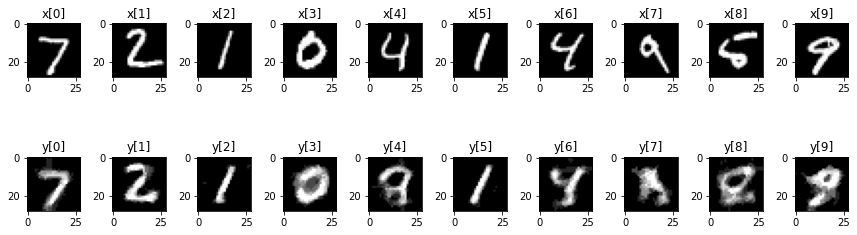

In [15]:
plt.figure(figsize=(12,4))
for i in range(10):
    plt.subplot(2, 10, i+1)
    plt.title('x[%d]'%i)
    plt.imshow(x[i][0], 'gray')
    plt.subplot(2, 10, i+11)
    plt.title('y[%d]'%i)
    plt.imshow(y[i][0], 'gray')
plt.tight_layout()